In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk import tokenize
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from string import punctuation
from razdel import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('e-catalog_phone_reviews.csv', index_col=0)

In [3]:
df

,review,type
0,Советую модель на 128 GB. Именно Pro в ней ест...,/img/svg/review-smile-4.svg
1,"Телефон - огонь) Хорошая модель, мне понравило...",/img/svg/review-smile-4.svg
2,"Аппарат очень хороший,конечно рекомендую к пре...",/img/svg/review-smile-4.svg
3,"Уверен, что телефон своих денег стои, а баланс...",/img/svg/review-smile-3.svg
4,"Всем рекомендую) Итак, искал я телефон для пок...",/img/svg/review-smile-4.svg
...,...,...
3685,"Не берите,за эти деньги можно найти и получше....",/img/svg/review-smile-1.svg
3686,модель с серьезными недостатками Тот телефон у...,/img/svg/review-smile-1.svg
3687,модель с серьезными недостатками Игры вылетают...,/img/svg/review-smile-1.svg
3688,"хорошая модель, понравилось У меня есть этот т...",/img/svg/review-smile-3.svg


## Преобразуем к четырем типам

####  (/img/svg/review-smile-4.svg) --> 1

####  (/img/svg/review-smile-3.svg) --> 2

####  (/img/svg/review-smile-2.svg) --> 3

####  (/img/svg/review-smile-1.svg) --> 4

In [4]:
def convert_to_4_types(val):
    if val == '/img/svg/review-smile-4.svg':
        return 1
    elif val == '/img/svg/review-smile-3.svg':
        return 2
    elif val == '/img/svg/review-smile-2.svg':
        return 3
    elif val == '/img/svg/review-smile-1.svg':
        return 4

In [5]:
df['type'] = df['type'].apply(lambda x: convert_to_4_types(x))

In [6]:
df['type'].value_counts(normalize=True)

1    0.565618
2    0.237527
4    0.098427
3    0.098427
Name: type, dtype: float64

## Text Preprocessing

### Приведем к нижнему регистру

In [7]:
df['review'] = df['review'].str.lower()

### Уберем лишние символы

In [8]:
pat = r'[^0-9a-zA-zа-яёА-ЯЁ\-]'

def clean_str(val):
    
    val = re.sub(pat, ' ', val)
    
    val = val.replace(' -', ' ')
    val = val.replace('- ', ' ')
    val = val.replace(' - ', ' ')
    val = val.replace('  ', ' ')
    val = val.strip()
    
    return val

df['review'] = df['review'].apply(lambda x: clean_str(x))

### Токенизируем

In [9]:
df['review'] = df['review'].apply(lambda x: [y.text for y in tokenize(x)])

### Уберем стоп-слова и одиночные буквы

In [10]:
stop_words = stopwords.words('russian') + stopwords.words('english')

In [11]:
df['review'] = df['review'].apply(lambda x: [y for y in x if y not in stop_words and len(y) > 1])

### Лемматизация

In [12]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
    
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_list):
    doc = Doc(' '.join(text_list))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    # лемматизация русских слов
    for token in doc.tokens:    
        token.lemmatize(morph_vocab)
    
    result = [x.lemma for x in doc.tokens]
    
    # лемматизация английских слов
    result = [lemmatizer.lemmatize(x) for x in result]

    return result

In [13]:
df['review'] = df['review'].apply(lambda x: lemmatize_text(x))

In [14]:
df['review'] = df['review'].apply(lambda x: ' '.join(x))

In [15]:
df.head()

,review,type
0,советовать модель 128 gb именно pro нужный оче...,1
1,телефон огонь хороший модель понравиться игруш...,1
2,аппарат очень хороший рекомендовать преобретен...,1
3,уверенный телефон свой деньга стой баланс цена...,2
4,весь рекомендовать итак искать телефон покупка...,1


## Count Vectorizer

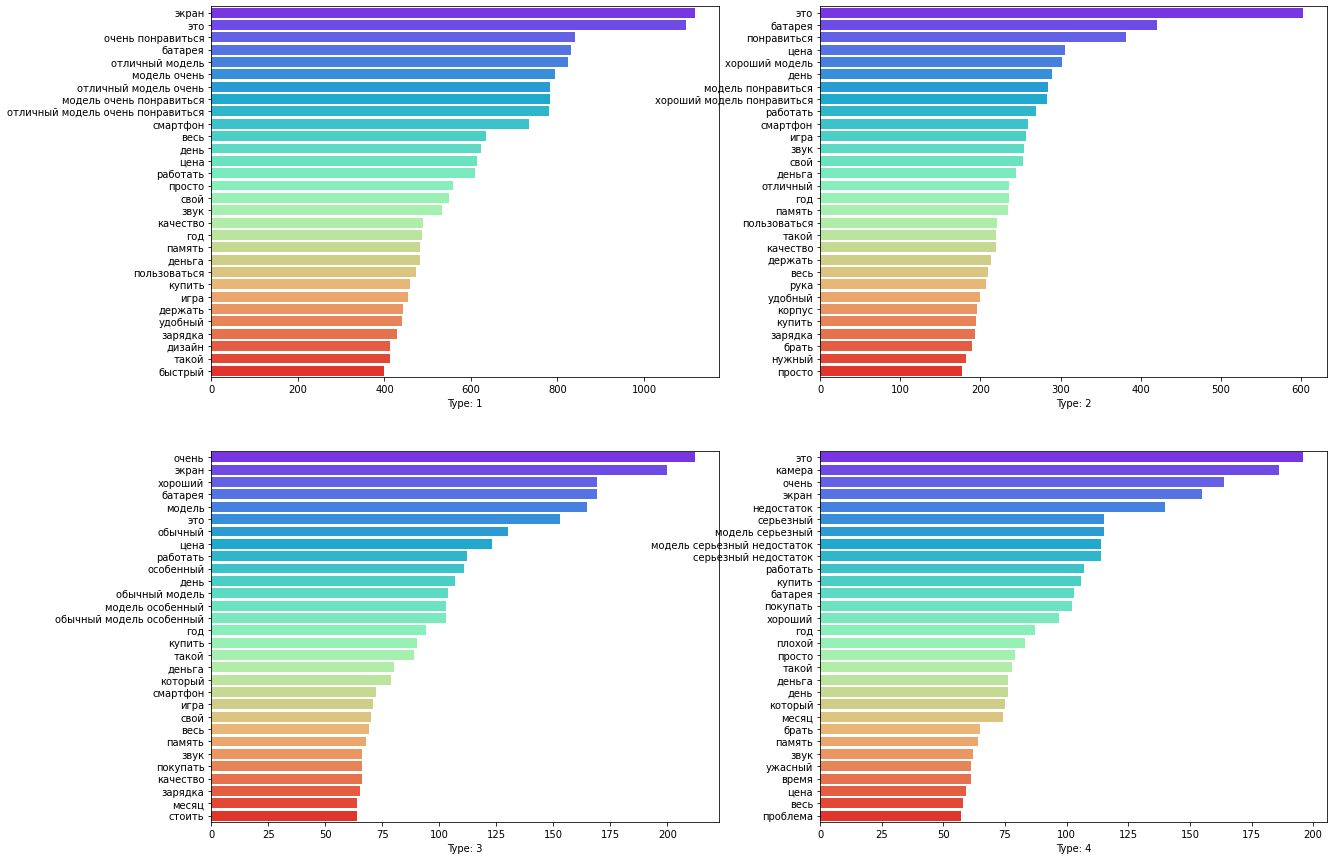

In [16]:
fig,ax = plt.subplots(2, 2, figsize=(20, 15))

i = 0
j = 0

for review_type in df['type'].unique():
    vectorizer = CountVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000)
    words = df.loc[df['type'] == review_type]['review'].to_list()
    vector = vectorizer.fit_transform(words)
    series = pd.DataFrame(data=vector.toarray(), 
                          columns=vectorizer.get_feature_names()).sum().sort_values(ascending=False)
    
    if j == 2:
        i += 1
        j = 0
    
    ax[i, j].set_xlabel(f'Type: {review_type}')
    sns.barplot(x=series.head(30), y=series.head(30).index, palette='rainbow', ax=ax[i, j])
    
    j += 1

## Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['type'], random_state=42, test_size=0.25)

## TF IDF

In [18]:
tf_idf_vec = TfidfVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000, norm=False)

X_train_tf = tf_idf_vec.fit_transform(X_train)
X_train_tf = pd.DataFrame(data=X_train_tf.toarray(), columns=tf_idf_vec.get_feature_names())

X_test_tf = tf_idf_vec.transform(X_test)
X_test_tf = pd.DataFrame(data=X_test_tf.toarray(), columns=tf_idf_vec.get_feature_names())

In [19]:
print(len(X_train_tf), len(X_test_tf))

2766 922


## Plot Feature Importance

In [20]:
def plot_feature_impotance(feature_impotance_array):
    fig, ax = plt.subplots(2, 2, figsize=(25, 15))

    i = 0
    j = 0

    labels = ['Positive', 'Semi-Positive', 'Semi-Negative', 'Negative']

    for label in range(len(feature_impotance_array)):
        featureImportance = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array[label] != 0], 
                                          "importance": feature_impotance_array[label][feature_impotance_array[label]!=0]}).sort_values(by='importance', ascending=False).head(25)

        if j == 2:
            i += 1
            j = 0

        ax_i = ax[i, j]

        sns.barplot(x='importance', y='feature', data=featureImportance, ax=ax_i)

        ax_i.set_xlabel(labels[label])
        ax_i.set_ylabel(None)

        j += 1

## Naive Bayes

In [21]:
mnnb = MultinomialNB()
mnnb.fit(X_train_tf, y_train)
preds = mnnb.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8875    0.7813    0.8310       535
           2     0.5423    0.6878    0.6065       205
           3     0.5172    0.4945    0.5056        91
           4     0.6346    0.7253    0.6769        91

    accuracy                         0.7267       922
   macro avg     0.6454    0.6722    0.6550       922
weighted avg     0.7492    0.7267    0.7338       922



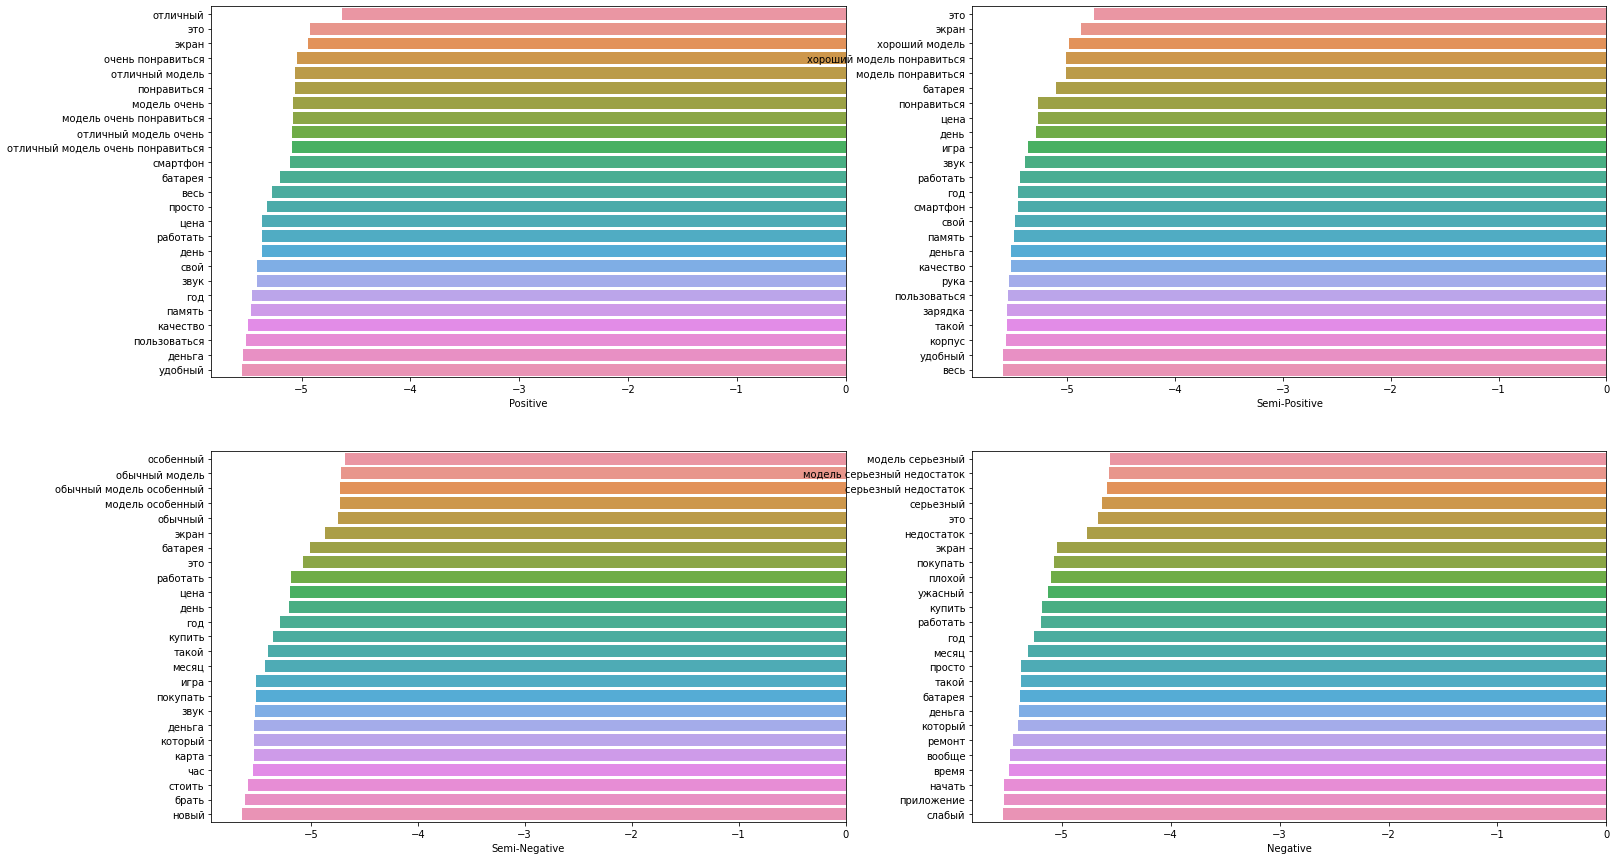

In [22]:
plot_feature_impotance(mnnb.coef_)

## Random Forest

In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train)
preds = rf.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.7155    0.9589    0.8195       535
           2     0.6864    0.3951    0.5015       205
           3     0.9355    0.3187    0.4754        91
           4     0.8571    0.5275    0.6531        91

    accuracy                         0.7278       922
   macro avg     0.7986    0.5500    0.6124       922
weighted avg     0.7447    0.7278    0.6984       922



### SVM

In [24]:
svm = SVC(random_state=42)
svm.fit(X_train_tf, y_train)
preds = svm.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.6721    0.9963    0.8027       535
           2     0.8904    0.3171    0.4676       205
           3     1.0000    0.2637    0.4174        91
           4     0.9688    0.3407    0.5041        91

    accuracy                         0.7082       922
   macro avg     0.8828    0.4794    0.5479       922
weighted avg     0.7823    0.7082    0.6607       922



## Logistic Regression

In [25]:
lr_no_reg = LogisticRegression(random_state=42, penalty='none')
lr_no_reg.fit(X_train_tf, y_train)
preds = lr_no_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8202    0.8187    0.8195       535
           2     0.5475    0.5902    0.5681       205
           3     0.4773    0.4615    0.4693        91
           4     0.7342    0.6374    0.6824        91

    accuracy                         0.7148       922
   macro avg     0.6448    0.6270    0.6348       922
weighted avg     0.7172    0.7148    0.7155       922



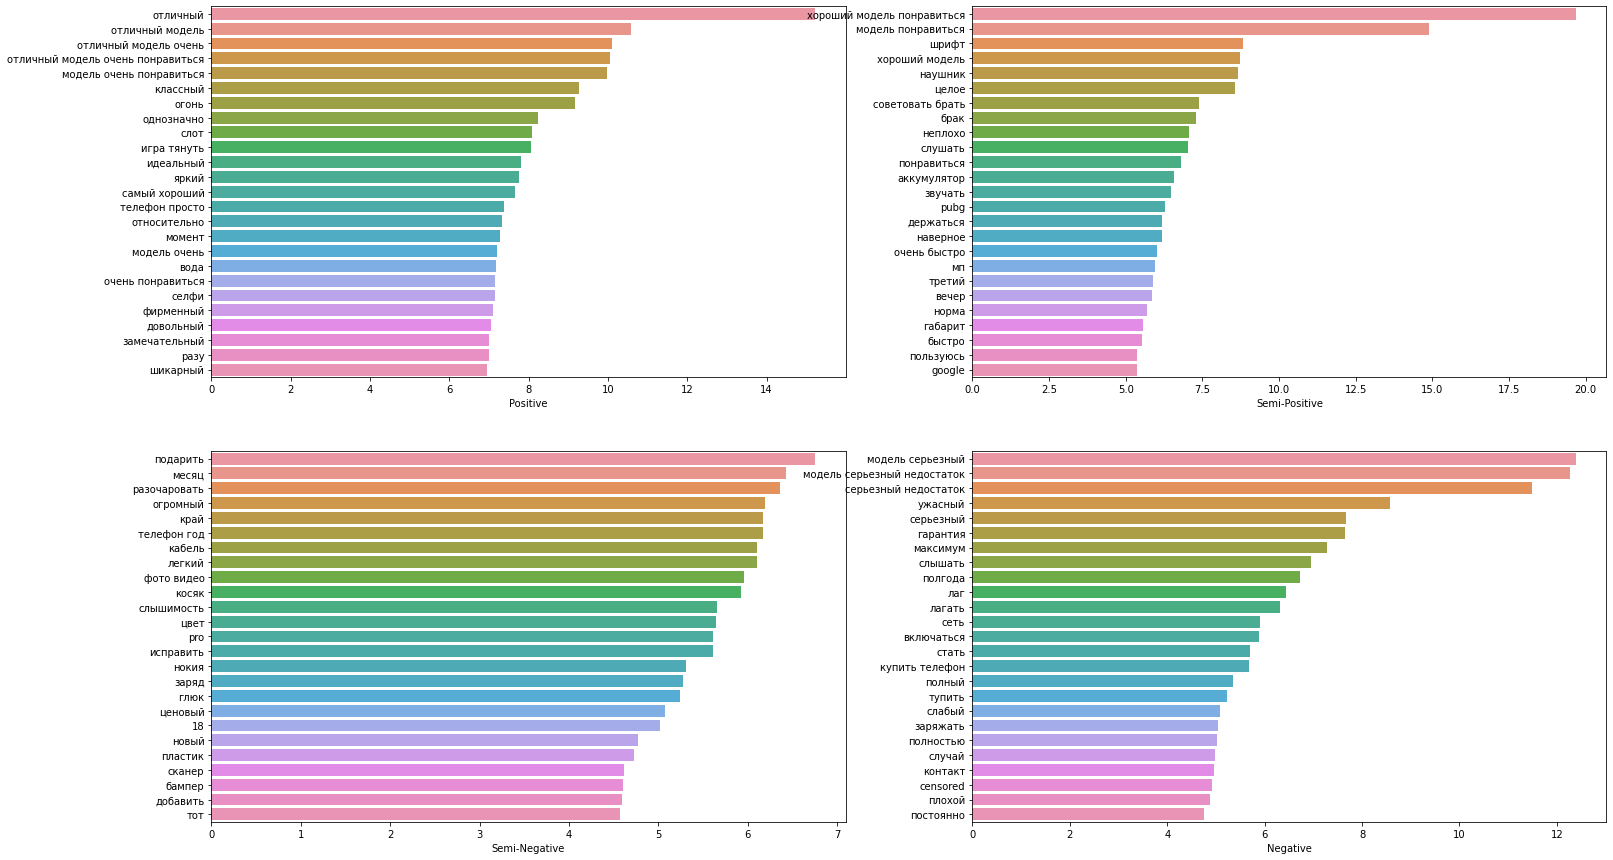

In [26]:
plot_feature_impotance(lr_no_reg.coef_)

In [27]:
lr_l2_reg = LogisticRegression(random_state=42, penalty='l2')
lr_l2_reg.fit(X_train_tf, y_train)
preds = lr_l2_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8091    0.8000    0.8045       535
           2     0.5153    0.5756    0.5438       205
           3     0.4217    0.3846    0.4023        91
           4     0.6914    0.6154    0.6512        91

    accuracy                         0.6909       922
   macro avg     0.6094    0.5939    0.6004       922
weighted avg     0.6939    0.6909    0.6917       922



/home/kostya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


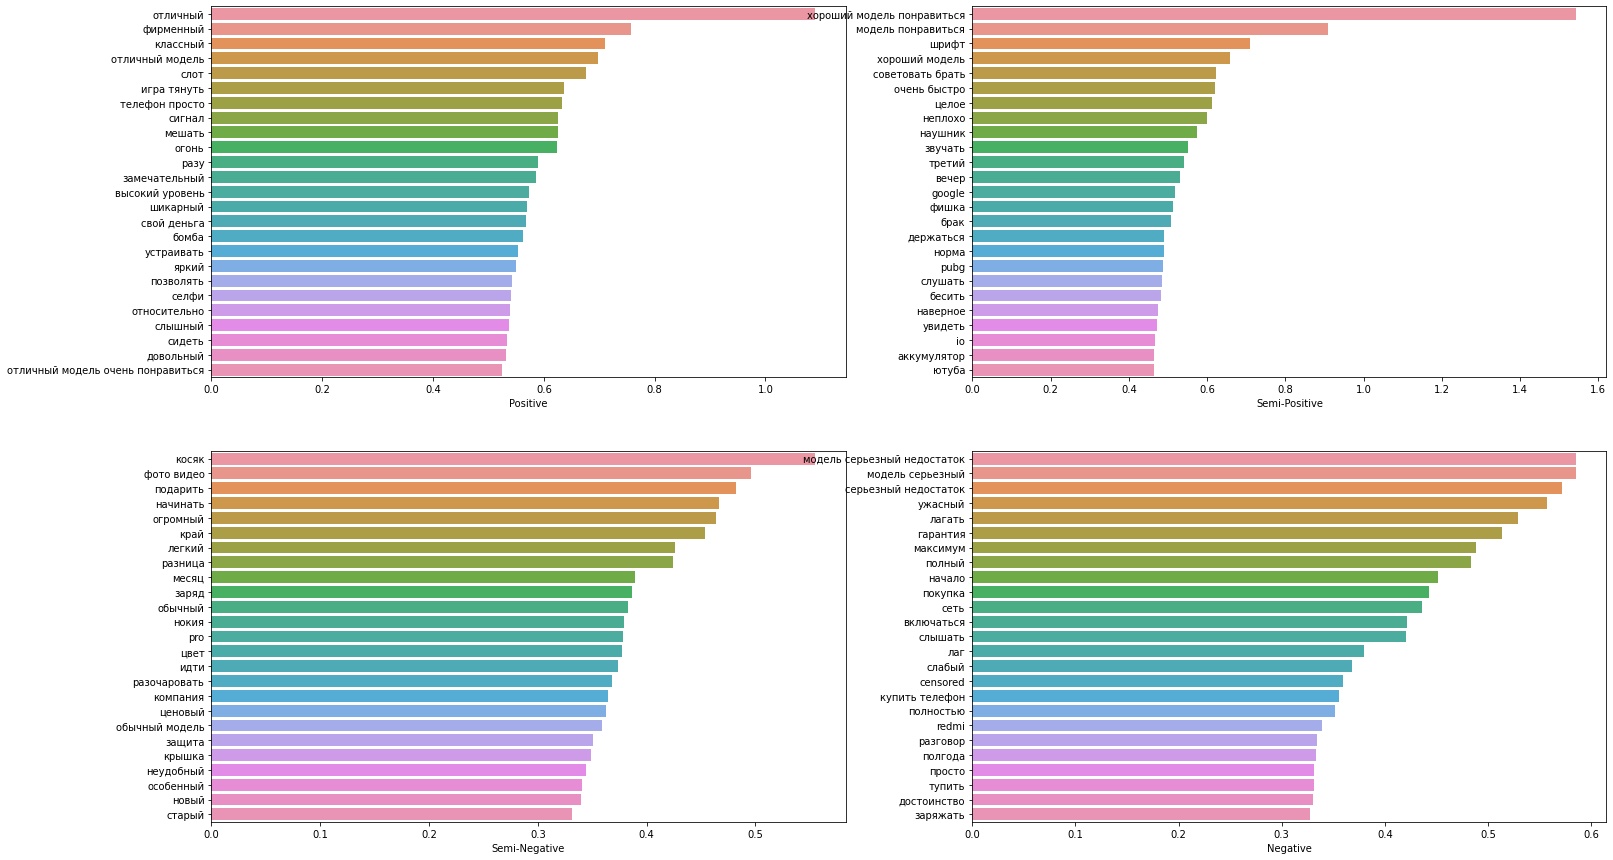

In [28]:
plot_feature_impotance(lr_l2_reg.coef_)

In [29]:
lr_l1_reg = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
lr_l1_reg.fit(X_train_tf, y_train)
preds = lr_l1_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8160    0.8206    0.8183       535
           2     0.5336    0.5805    0.5561       205
           3     0.4824    0.4505    0.4659        91
           4     0.7895    0.6593    0.7186        91

    accuracy                         0.7148       922
   macro avg     0.6554    0.6277    0.6397       922
weighted avg     0.7177    0.7148    0.7154       922



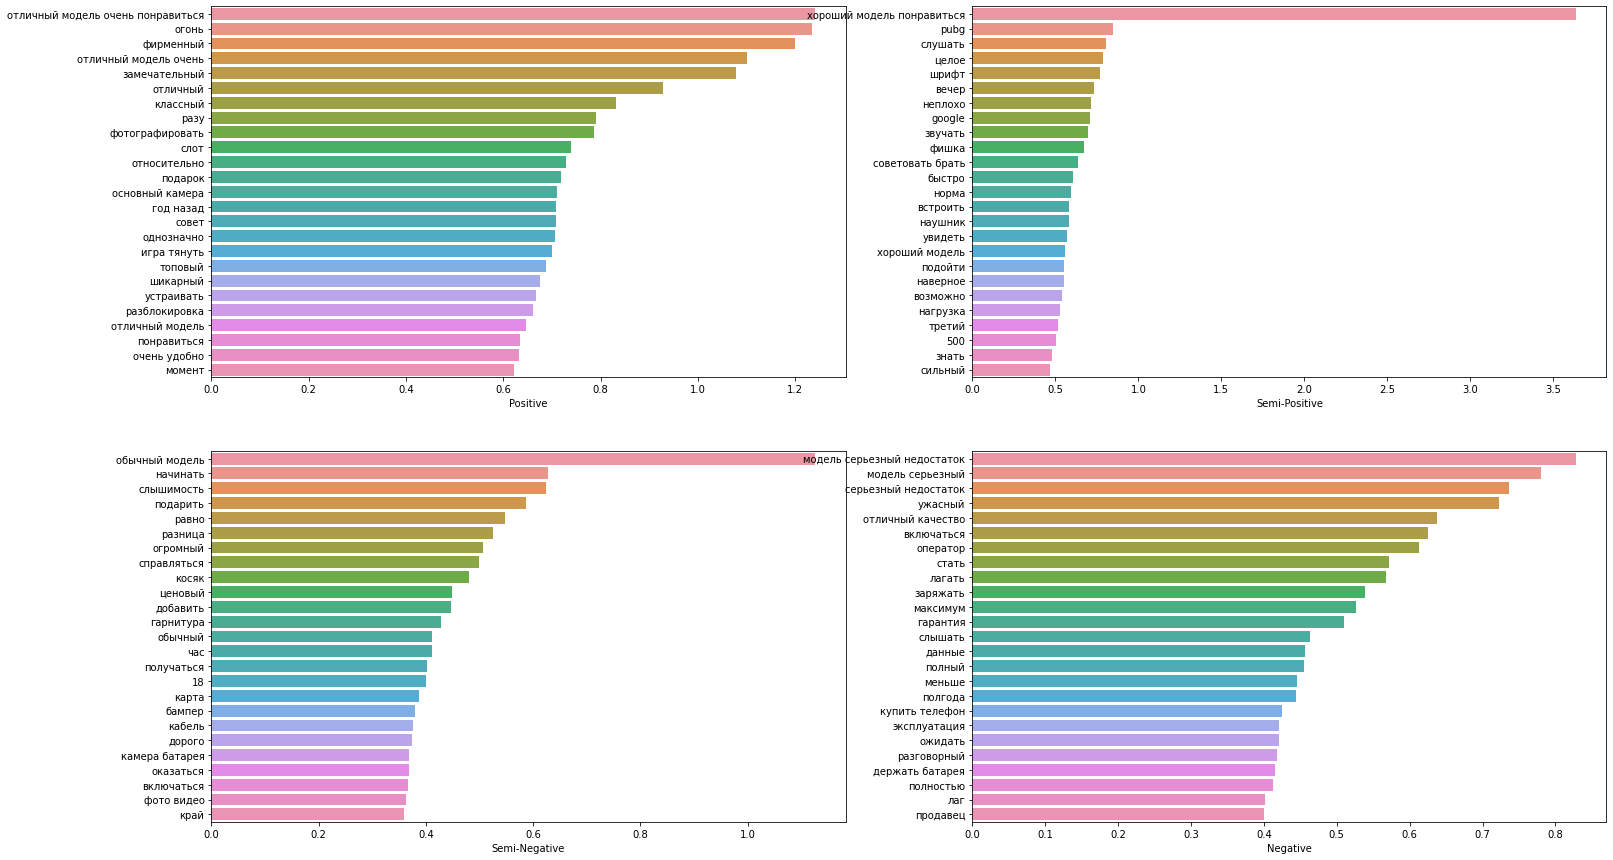

In [30]:
plot_feature_impotance(lr_l1_reg.coef_)